<a href="https://www.kaggle.com/yongwonjin/titanic-survival-classification?scriptVersionId=89088446" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Titanic Survival Classification
Based on the notebooks by:  
[Alexis Cook](http://www.kaggle.com/alexisbcook/titanic-tutorial)  
[Francisco Javier Gallego](https://www.kaggle.com/javigallego/top-5-hyperparameter-tuning-ensemble-modeling?scriptVersionId=88795500)  
[Woo Seung Han](https://www.kaggle.com/hadeux/titanic-survivor-predict-eda-lightgbm-kor-eng/notebook)  

In [1]:
# autocomplete ON
%config Completer.use_jedi = False

In [2]:
# Load libraries
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt


<div style='color: white; display: fill; 
    border-radius: 8px; background-color: black;
    font-size: 150%; letter-spacing:0.5px'> 
    <p style='padding: 8px; color: white;'> 
        <b>1 &nbsp; Data prep & EDA</b>
    </p>
</div> 

### <b> 1.1 <span style='color:green'> | </span> Load data </b>

In [3]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [4]:
# Load train and test data
df_train = pd.read_csv('../input/titanic/train.csv')
df_test = pd.read_csv('../input/titanic/test.csv')
gender_submission = pd.read_csv('../input/titanic/gender_submission.csv')

# Concatenate two data sets
df_data = pd.concat([df_train, df_test], sort=True).reset_index(drop=True)
dfs = [df_train, df_test]

### <b> 1.2 <span style='color:green'> | </span> EDA </b>

In [5]:
## Visually inspect first few rows of each table
# df_train.head(3)
# df_test.head(3)
gender_submission.head(3)

### Task is to predict "Survived" for each "PassengerId"

,PassengerId,Survived
0,892,0
1,893,1
2,894,0


In [6]:
## Show table schema
# df_train.info()
# df_test.info()
df_data.info()

### Excluding the Id and independent variable, there are 10 features

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1046 non-null   float64
 1   Cabin        295 non-null    object 
 2   Embarked     1307 non-null   object 
 3   Fare         1308 non-null   float64
 4   Name         1309 non-null   object 
 5   Parch        1309 non-null   int64  
 6   PassengerId  1309 non-null   int64  
 7   Pclass       1309 non-null   int64  
 8   Sex          1309 non-null   object 
 9   SibSp        1309 non-null   int64  
 10  Survived     891 non-null    float64
 11  Ticket       1309 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


In [7]:
# Check for any duplicates
df_data.duplicated().value_counts()

False    1309
dtype: int64

In [8]:
## Count missing values from each column
# df_train.isna().sum()
df_test.isna().sum()
# df_data.isna().sum()

### Columns "Age", "Cabin", and "Embarked" have missing values

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [9]:
def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.1, .9), xycoords=ax.transAxes)
    
def pairPlot(data, column=None):
    if column:
        num = len(data[column].unique())
        g = sns.PairGrid(data, hue=column, hue_kws=sns.color_palette('vlag', n_colors=2, as_cmap=True), dropna=True)
        g.map_offdiag(sns.scatterplot)
        g.add_legend()
    else:
        g = sns.PairGrid(data, dropna=True)
        g.map_offdiag(corrfunc)
        g.map_offdiag(sns.regplot)
    g.map_diag(sns.histplot)
    return g

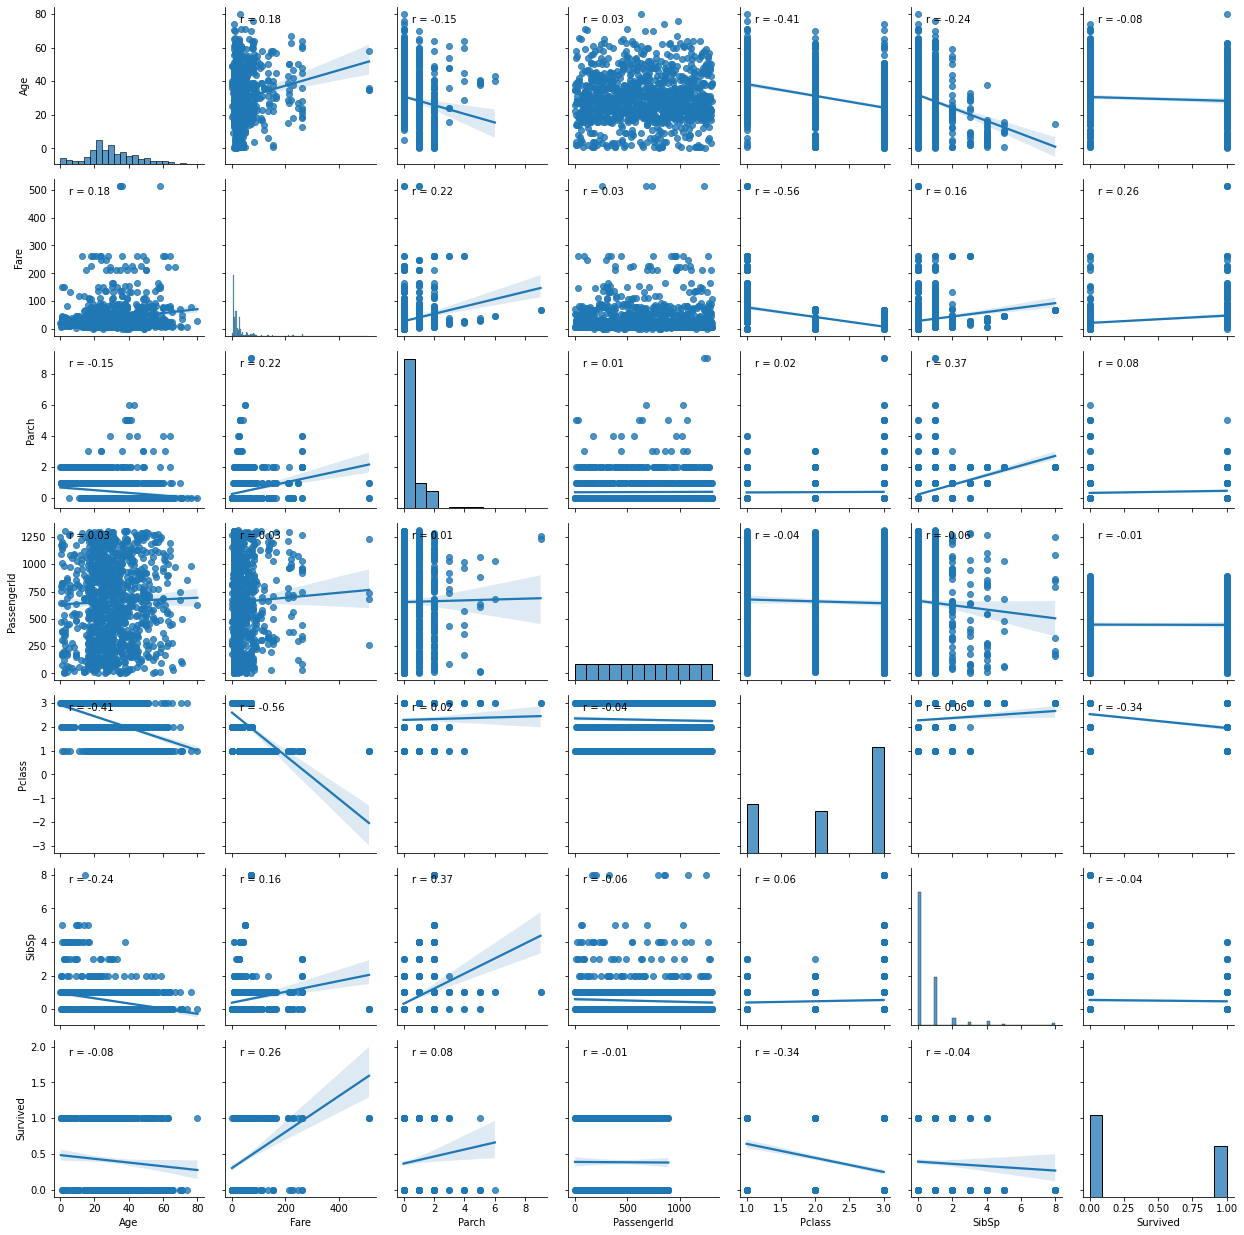

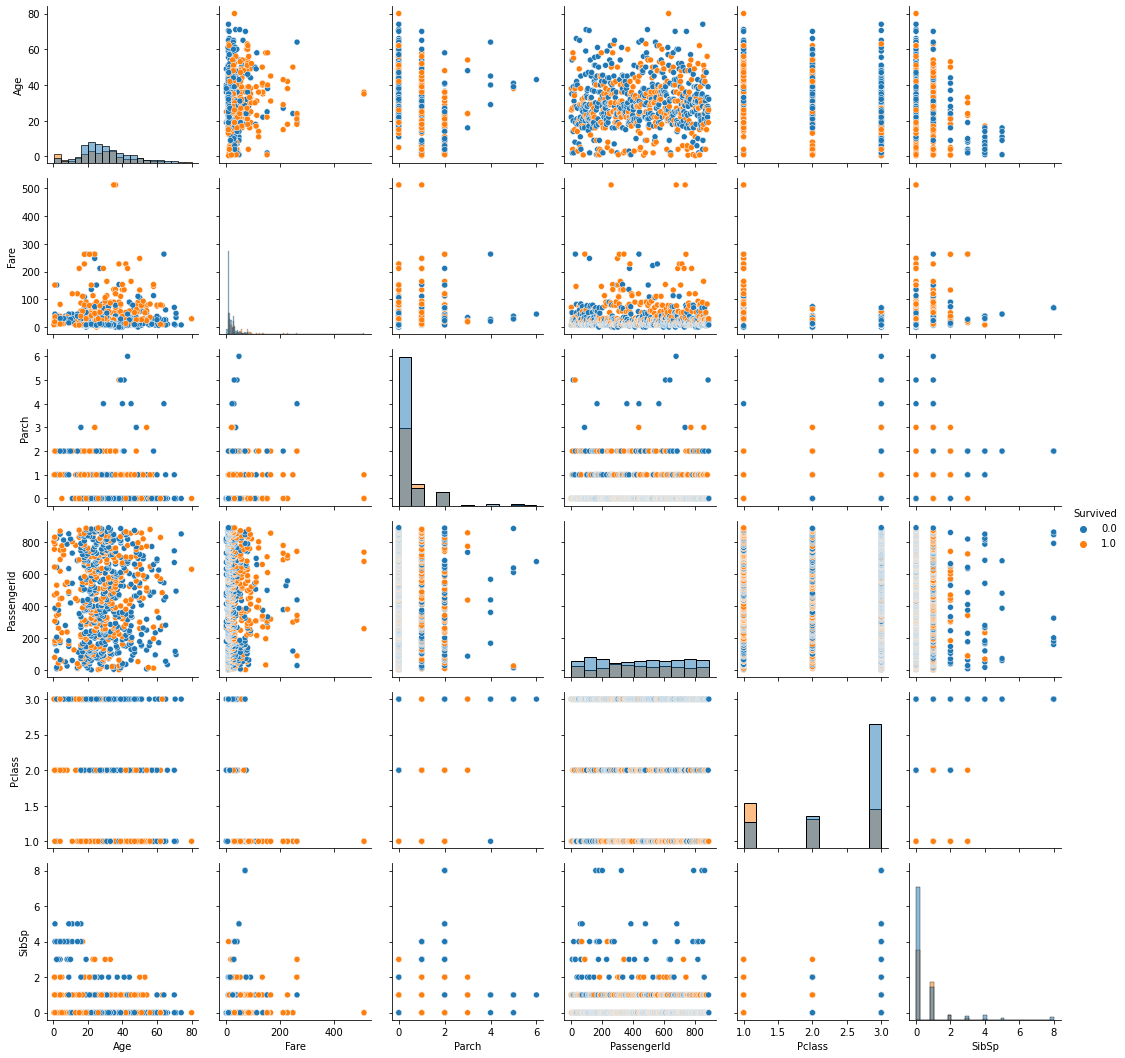

In [10]:
# Visualize pair-wise distribution using a pair plot
pairPlot(df_data)
pairPlot(df_data, 'Survived')
# sns.pairplot(data=df_data, kind = 'reg')
# sns.pairplot(data=df_data, kind = 'hist', hue='Survived', palette={0:'blue',1:'green'})

### In the training data, more people died than survived
### 

<AxesSubplot:>

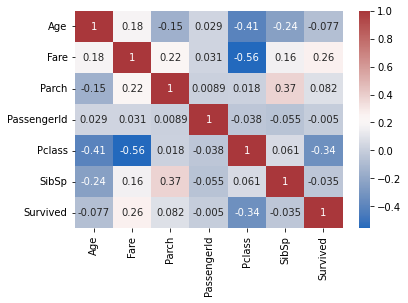

In [11]:
# Heat map to visualize correlation between variables
sns.heatmap(df_data.corr(), annot=True, cmap='vlag')

In [12]:
# Tally groups to see which features may be important for survival
df_train.groupby(['Survived', 'Parch']).size()

Survived  Parch
0         0        445
          1         53
          2         40
          3          2
          4          4
          5          4
          6          1
1         0        233
          1         65
          2         40
          3          3
          5          1
dtype: int64

In [13]:
# Percent of women that survived
women = df_train.loc[df_train.Sex == 'female']['Survived']
pct_women = sum(women)/len(women)
print('% of women who survived:', pct_women)

# Percent of men that survived
men = df_train.loc[df_train.Sex == 'male']['Survived']
pct_men = sum(men)/len(men)
print('% of men who survived:', pct_men)

% of women who survived: 0.7420382165605095
% of men who survived: 0.18890814558058924


In [14]:
from sklearn.ensemble import RandomForestClassifier

Y_train = df_train['Survived']

features = ['Pclass', 'Sex', 'SibSp', 'Parch']
X_train = pd.get_dummies(df_train[features])
X_test = pd.get_dummies(df_test[features])

model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=7)
model.fit(X_train,Y_train)

RandomForestClassifier(max_depth=5, random_state=7)

In [15]:
predictions = model.predict(X_train)
acc_train = (1 - sum(abs(predictions - Y_train.to_numpy())) / len(predictions))
print('Prediction accuracy on training set: ', acc_train)

Prediction accuracy on training set:  0.8148148148148149


In [16]:
predictions = model.predict(X_test)

output = pd.DataFrame({'PassengerId': df_test.PassengerId, 
                      'Survived': predictions})
# output.to_csv('submission.csv', index=False)
print('Your submission was successfully saved!')

Your submission was successfully saved!
